Code adapted from: 

Earth Lab's Earth Data Analytics -- Lesson 2. Subtract One Raster from Another and Export a New GeoTIFF in Open Source Python

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/subtract-rasters-in-python/

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install rioxarray
!pip install earthpy

In [33]:
import os
import asdc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")
!pwd

/home/jovyan/tim.brown@anu.edu.au/segment-anything


In [34]:
print("Select the task to download the DSM and DTM from. Make sure the Task you have selected actually has both a DSM and a DTM file")
asdc.task_select()
from ipywidgets import widgets

Select the task to download the DSM and DTM from. Make sure the Task you have selected actually has both a DSM and a DTM file


interactive(children=(Dropdown(description='project', index=7, options=(('3: Misc Testing Projects', 3), ('5: …

interactive(children=(Dropdown(description='task', index=13, options=(('USLN-Coolama-RGB-2022-02-11-DJI-M3-Zac…

Button(description='Run all below', icon='play', style=ButtonStyle())

In [35]:
project_id, task_id = asdc.get_selection()
task_name = asdc.task_dict[task_id]['name']
project_id
task_id
print("Task name = ", task_name)

Task name =  USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB | 2023-04-17 (reprocess w/high res ortho settings)


Now we download the DSM and DTM files

In [8]:
temp_folder_name = "TEMP-" + task_name.split(" |")[0]

task_data_folder_path = os.path.join(".", temp_folder_name)  # The '.' represents the current directory

if not os.path.exists(task_data_folder_path):
    os.makedirs(task_data_folder_path)

Now we download the DSM and DTM files from the selected Task.

Note that this step will fail if your task doesn't have either of these files. 

If not, you will need to re-run the task and make sure creation of both DSM & DTM is enabled in the Task processing options.

In [36]:
# Use this code to download via URL rather than with the ASDC API
#  or if you want to have the DSM/DTM files have the task name
#   DSM_path = f"https://asdc.cloud.edu.au/api/projects/{project_id}/tasks/{task_id}/download/dsm.tif"
#   DTM_path = f"https://asdc.cloud.edu.au/api/projects/{project_id}/tasks/{task_id}/download/dtm.tif"

print("Downloading DSM and DTM files to: ", task_data_folder_path)

## Note that I couldn't figure out how to download these files to a sub folder:

#inputs = asdc.get_inputs()
filename = 'dsm.tif'
asdc.download_asset(filename)

filename = 'dtm.tif'
asdc.download_asset(filename)



'dtm.tif'

Open and plot the lidar digital elevation model (DEM). Note that when you read the data, you can use the argument masked = True to ensure that the no data values do not plot and are assigned nan or nodata.

In [27]:
#In ODM, the DEM is called a DTM

#lidar_dem_path = "USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB-2023-04-17-reprocess-w-high-res-ortho-settings-dtm.tif"

lidar_dem_path = "dtm.tif"

# Open lidar dem
lidar_dem_xr = rxr.open_rasterio(lidar_dem_path, masked=True).squeeze()
lidar_dem_xr

<xarray.DataArray (y: 2524, x: 3637)>
[9179788 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 6.625e+05 6.625e+05 ... 6.627e+05 6.627e+05
  * y            (y) float64 5.973e+06 5.973e+06 ... 5.973e+06 5.973e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Import Digital Surface Model (DSM)
Next, you will open the digital surface model (DSM). The DSM represents the top of the earth’s surface. Thus, it includes trees, buildings and other objects that sit on the earth.

In [37]:
# Define relative path to file
# lidar_dsm_path = os.path.join("colorado-flood",
#                               "spatial",
#                               "boulder-leehill-rd",
#                               "pre-flood",
#                               "lidar",
#                               "pre_DSM.tif")

#lidar_dsm_path = "USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB-2023-04-17-reprocess-w-high-res-ortho-settings-dsm.tif"

lidar_dsm_path = "dsm.tif"

# Open lidar dem
lidar_dsm_xr = rxr.open_rasterio(lidar_dsm_path, masked=True).squeeze()
lidar_dsm_xr

<xarray.DataArray (y: 2524, x: 3637)>
[9179788 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 6.625e+05 6.625e+05 ... 6.627e+05 6.627e+05
  * y            (y) float64 5.973e+06 5.973e+06 ... 5.973e+06 5.973e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Before you subtract the two rasters. Before performing this calculate however you should check to ensure that they cover the same spatial extent and are of the same spatial resolution (pixel size).

In [38]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      lidar_dem_xr.rio.bounds() == lidar_dsm_xr.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      lidar_dem_xr.rio.resolution() == lidar_dsm_xr.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


If it looks like the bounds and resolution are the same. This means it is safe for you to subtract the two rasters without significant errors or uncertainty introduced.

Below you calculate the difference between the two arrays to generate a Canopy Height Model. You then plot your newly created canopy height model.

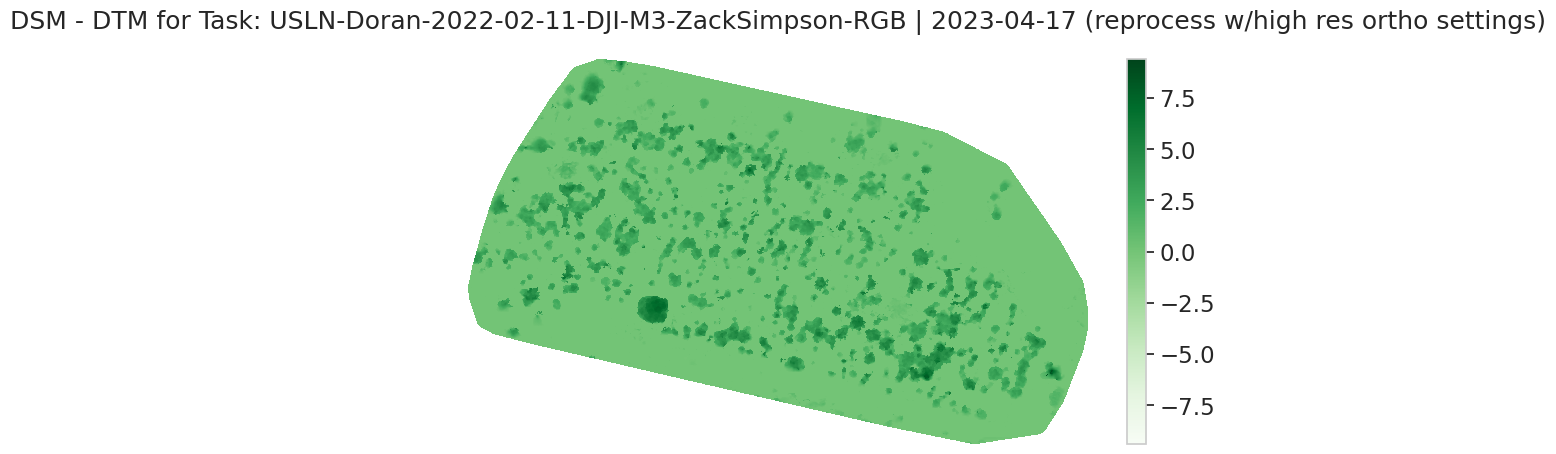

In [45]:
# Calculate canopy height model
lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr

# Plot the data
f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_xr.plot(cmap="Greens")

ax.set(title=  "DSM - DTM for Task: " + task_name)
ax.set_axis_off()
plt.show()

In [26]:
lidar_chm_xr

<xarray.DataArray (y: 2524, x: 3637)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 6.625e+05 6.625e+05 ... 6.627e+05 6.627e+05
  * y            (y) float64 5.973e+06 5.973e+06 ... 5.973e+06 5.973e+06
    spatial_ref  int64 0